# Pog/Kappa Meter

The aim of this project is to provide a "Pog vs Kappa" comparison for each streamer's channel over a given period of time and use these labels to analyze sentiment. Emotes of type "Pog" correspond to excitement, whereas "Kappa" corresponds to sarcasm. We can think of these emotes as measure of enjoyment versus playfulness for a streamer's channel. Ideally, we would be able to measure sentiment by capturing emotes that show enjoyment, but sometimes emotes are used sarcastically. For example, it is not uncommon to see both of the following comments:
> First place! PogChamp

> Last place! PogChamp

Clearly, the last comment is sarcastic. In order to account for this, we measure the "troll-y-ness" of the channel.

Once we create a model to predict the emotes, we will evaluate the sentiment of chatrooms by counting appearances of emotes explicity written in messages as well as classifying text without emotes using our neural network.

The main difficulty in building a sentiment classifier for chat room messages is the noisiness of the data. There are several grammatical errors, "trolling" messages, spam messages, and sarcastic messages. Our model makes a first attempt at building a reasonable classifier, but it can be improved by further preprocessing and carefully selecting emote groups.

## Table of Contents

1. [Preprocessing](##preprocessing)
2. [Embedding](##embedding)
3. [Learning](##learning)
4. [Sentiment Analysis](##sentiment)

In [3]:
%tensorflow_version 2.x

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [1]:
import pandas as pd
import os
import re
import requests
import json
import twokenize
import pickle
import numpy as np
from datetime import datetime

### Preprocessing

In order to properly train our data, we will need to combine the 52 pickled data sets into one large data set, which is over 12 GB. Since the size is too large for memory, we will have to preprocess each data set individually, and preprocess chunks of the individual data sets themselves when they are too large. To carry this out, we saved our pickled files as csv files since ```pandas``` can read csv files piece by piece, whereas pickled files cannot be read in this way. (In the end, this was unnecessary, but we chose to save our files to csv anyway.)

The goal of our preprocessing step is to filter unwanted messages while also labeling the messages according to the emotes used. We first load in our list of streamers, which were obtained manually. They are listed by size in descending order.

In [74]:
streamers = pickle.load(open("streamers.pkl", "rb"))
streamers[:5]

['sodapoppin', 'shroud', 'lirik', 'moonmoon_ow', 'ninja']

We load the pickled files one by one, selecting only the columns that may be useful later on. This reduces the size of the data by 25%.

In [ ]:
for streamer in streamers:
  df = pd.read_pickle(streamer+'.pkl')
  df = df.drop(columns=['updated_at', 'commenter_type', 'offset', 'video_id', 'commenter_id'])
  df.to_csv(streamer + '_trim.csv')
  del df

Once we have trimmed the size our data set and saved the dataframes to csv files, we are ready to start preprocessing our data. We will create a function that preprocesses any dataframe given to it. Our goal is to remove any hyperlinks, non-ASCII characters, tokenize the data. We choose to leave punctuation in our text since there is some benefit for our models.

In [ ]:
def process_df(df):
    df['body'] = df['body'].apply(lambda x: re.sub("http\S+|[^\x00-\x7F]", "", str(x)))
    df['tokens_body'] = df['body'].apply(lambda x: twokenize.tokenizeRawTweetText(x))
    df['counts'] = df['tokens_body'].apply(lambda x: len(x))
    df['u_counts'] = df['tokens_body'].apply(lambda x: len(set(x)))
    
    # Remove sentences with fewer than 5 unique words. We will apply a modified version of this filter again later on.
    df = df[df['u_counts'] >= 5]
    df['date'] = df['created_at'].apply(lambda x: datetime.strptime(datetime.strftime(x, '%Y %m %d %H'), '%Y %m %d %H'))
    
    return df[['date','body','tokens_body']]

In [ ]:
for streamer in streamers:
    df = pd.read_csv('trimmed_data/' + streamer + '_trim.csv', usecols=['body','created_at'], parse_dates=['created_at'])
    df = process_df(df)
    df.to_csv('tokenized_data/' + streamer +'_tokenized.csv')
    del df

We will request the list of emotes from Twitch using an api. This can only be used to grab global emotes and streamer-specific emotes. Global emotes are not as popular as they once were, but still common enough that they should be used. Streamer-specific emotes are emotes accessible only to paid subscribers to a channel and are frequently used. The last group of emotes is obtained manually from [FrankerFaceZ](https://www.frankerfacez.com/emoticons/). These emotes are similar in function to the global emotes and have since replaced them. We only use the 100 most popular emotes used on Twitch.

Emotes serve two purposes: 

*   They provide a way to label our data and classify sentiment, similar to techniques used for Twitter sentiment analysis. (See [Towards the Understanding of Gaming Audiences by Modeling Twitch Emotes](https://pdfs.semanticscholar.org/1260/f76d10ec66dda257070ce4dcdbab800ec501.pdf)).
*   We will need to filter these emotes out of the so that our model cannot cheat, and also to filter out noise in our messages.



In [70]:
# Get global emotes. Some have become less popular in favor of FrankerFace emotes.

global_response = requests.get('https://api.twitch.tv/kraken/chat/emoticon_images?emotesets=0', headers={
                               'Accept': 'application/vnd.twitchtv.v5+json', 'Client-ID': '4f7ls48eaq2lly25dyuiead8o5ydev'})
json_data_global = json.loads(global_response.text)
global_emotes = json_data_global.get('emoticon_sets').get('0')
global_emotes = set([i.get("code") for i in global_emotes])

In [71]:
# Function for grabbing emotes specific to a particular streamer. Only subscribers to the streamer's channel can use these.

def streamer_emotes(streamer):
    channel_ids = pickle.load(open('channel_ids.pkl', 'rb'))
    response = requests.get('https://api.twitchemotes.com/api/v4/channels/' + channel_ids[streamer])
    json_data = json.loads(response.text)
    emotes = json_data.get("emotes")
    X = set([i.get("code") for i in emotes])

    return X

In [72]:
# Load top 96 FrankerFaceZ emotes.
topffemotes = set(pickle.load(open('top100ffemotes.pkl', 'rb')))


In this final preprocessing step, we will label our data and filter emotes from our tokens. From here, we will be able to use these dataframes for our word embeddings.

In [7]:
def process_tokens(streamer):
  df = pd.read_csv('tokenized_data/' + streamer + '_tokenized.csv', parse_dates=['date'])

  kappas = {'Kapp', 'Kappa', 'KappaClaus', 'KappaPride', 'KappaRoss', 'KappaWealth', 'Kappu', 'Keepo'}
  pogs = {'POGGERS','Pog','PogChamp','PogU','PogYou','Pogey'}

  X = global_emotes.union(streamer_emotes(streamer)).union(topffemotes)
  df['tokens_body'] = df['tokens_body'].apply(lambda x: eval(x))
  df['unique emotes'] = df['tokens_body'].apply(set)
  df['unique emotes'] = df['unique emotes'].apply(lambda x: x.intersection(set(X)))

  df['emote_counts'] = df['unique emotes'].apply(lambda x: len(x))
  df_filt = df[df['emote_counts'] > 0]

  df_filt['pog'] = df_filt['unique emotes'].apply(lambda x: 1 if len(x.intersection(pogs)) > 0 else 0)
  df_filt['kappa'] = df_filt['unique emotes'].apply(lambda x: 1 if len(x.intersection(kappas)) > 0 else 0)
  df_filt['mix'] = df_filt['pog'] + df_filt['kappa']
  df['u'] = df['tokens_body'].apply(lambda x: len(set(x)))
  df_filt = df_filt[df_filt['mix'] <= 1]
  df_filt['other'] = df_filt['mix'].apply(lambda x: 1 if x == 0 else 0)

  df_filt['tokens_minus_emotes'] = df_filt['tokens_body'].apply(lambda x: [i for i in x if i not in X])
  df_filt['u'] = df_filt['tokens_minus_emotes'].apply(lambda x: len(set(x)))
  df_filt = df_filt[df_filt['u'] >= 5]
  df_filt = df_filt.drop_duplicates(subset=['body'])
  df_filt['body_short'] = df_filt['tokens_minus_emotes'].apply(lambda x: ' '.join(x[:8]))
  df_filt = df_filt.drop_duplicates(subset=['body_short'])

  df_filt = df_filt[['date','tokens_minus_emotes','unique emotes','pog','kappa','other']]
  df_filt.to_csv('processed_tokens/' + streamer + '_proc.csv')

In [ ]:
streamers = pickle.load(open("streamers.pkl", "rb"))
for streamer in streamers:
  process_tokens(streamer)
  print(streamer + " processed.")

## Embeddings

The inputs for our neural network must be ```numpy``` arrays, so we will need to use word embeddings to vectorize our inputs. While we can train our own embedding layer in ```keras```, we find that better performance can be obtained using pre-trained embedding models.

One of the most common embedding models for NLP tasks is Google's Word2Vec. However, Word2Vec does not handle mispellings well, which can be an issue for processing chat room messages. Facebook's fastText is a more general model that learns character n-grams along with the word embedding as in Word2Vec. We will use fastText through the ```gluonnlp``` package.

We load in our data from the preprocessing stage.

In [27]:
streamers = pickle.load(open("streamers.pkl", "rb"))
df = pd.DataFrame()
for streamer in streamers:
  df_temp = pd.read_csv('processed_tokens/'+streamer+'_proc.csv', parse_dates=['date'])
  df = pd.concat([df,df_temp])
df

,Unnamed: 0,date,tokens_minus_emotes,unique emotes,pog,kappa,other
0,6,2018-05-20 20:00:00,"['VOD', 'FROGS', ',', 'WHISPER', 'ME', 'IF', '...",{'HeyGuys'},0,0,1
1,7,2018-05-20 20:00:00,"['@jakepaulfan999', 'hurry', 'up', 'with', 'yo...",{'Pog'},1,0,0
2,9,2018-05-20 20:00:00,"[""It's"", 'still', 'hosting', 'forsen', 'for', ...",{'monkaS'},0,0,1
3,30,2018-05-20 20:00:00,"['VOD', 'FROGS', 'WHISPER', 'ME', 'IF', 'YOU',...",{'sodaC'},0,0,1
4,37,2018-05-20 20:00:00,"['sodaHi', 'Thanks', 'for', 'staying', 'Furry'...",{'sodaB'},0,0,1
...,...,...,...,...,...,...,...
5663,54419,2018-06-22 00:00:00,"['If', 'only', 'I', 'could', 'hit', 'the', 'el...",{'FeelsBadMan'},0,0,1
5664,54429,2018-06-22 00:00:00,"['<', 'Well', 'Done', '>', 'EZ']",{'Clap'},0,0,1
5665,54438,2018-06-22 00:00:00,"[""that'll"", 'be', 'it', 'for', 'me', 'today']",{'FeelsBadMan'},0,0,1
5666,54451,2018-06-22 00:00:00,"['Type', '1', 'if', 'you', 'would', 'Kibler']",{'KappaPride'},0,1,0


In [28]:
# Frequency of labels in our data
labels = ['pog','kappa','other']
for label in labels:
    print(df[label].sum())

126292
204573
1788570


As we can see, messages are more frequently not of "pog" or "kappa" type, so we will need to sample our data so our model does not learn to simply guess "other" for every message. Another alternative is to use SMOTE, but after experimentation we found undersampling data is better for performance.

We will uniformize the length of our tokenized sentences to 20 tokens.

In [29]:
df['tokens_minus_emotes'] = df['tokens_minus_emotes'].apply(lambda x: eval(x))
df['pad_tokens'] = df['tokens_minus_emotes'].apply(lambda x: x[:20] if len(x) >= 20 else x+['']*(20-len(x)))

There are several choices for pre-trained fastText models, but we chose the default model due to size contraints.

In [ ]:
!pip install gluonnlp
!pip install mxnet

In [26]:
import gluonnlp as nlp
import mxnet as mx

fasttext = nlp.embedding.create('fasttext', source='wiki.simple', load_ngrams=True)
tokenized = [i for i in df['pad_tokens']]
tokens = [i for sub in tokenized for i in sub]
counter = nlp.data.count_tokens(tokens)
my_vocab = nlp.Vocab(counter)
my_vocab.set_embedding(fasttext)

Embedding file wiki.simple.npz is not found. Downloading from Gluon Repository. This may take some time.
Embedding file wiki.simple-67424112.bin is not found. Downloading from Gluon Repository. This may take some time.


We sample our data and save the embeddings since they take quite some time to create. The embeddings are 9 GB in total, and Google Colab limits the size of files that can be saved, so we split the embeddings into 3 chunks.

In [27]:
df_pog = df[df['pog'] == 1]
df_kappa = df[df['kappa'] == 1]
df_other = df[df['other'] == 1]

n = 120000
df_pograndom = df_pog.sample(n)
df_kapparandom = df_kappa.sample(n)
df_otherrandom = df_other.sample(n)

df_sample = pd.concat([df_pograndom,df_kapparandom,df_otherrandom]).sample(frac=1)

In [30]:
subset_tokenized = [i for i in df_sample['pad_tokens']]
embeddings = [my_vocab.embedding[i].asnumpy() for i in subset_tokenized]
embeddings = np.array(embeddings)

In [34]:
pickle.dump(embeddings[:120000],open("embeddings_array_0.pkl", "wb"))
pickle.dump(embeddings[120000:240000],open("embeddings_array_1.pkl", "wb"))
pickle.dump(embeddings[240000:],open("embeddings_array_2.pkl", "wb"))

## Learning

We now move to creating and training our model. It is well-known that LSTM layers work better than other layers such as convolutional layers for NLP tasks due its ability to account for long term word dependencies as well as short toerm dependencies (hence the name Long Short-Term Memory). Bi-directional LSTM layers improve upon LSTM layers by taking into account word dependencies that arise after a word appears in text, as opposed to simply looking at words appearing before the word in a traditional LSTM layer. 

In [88]:
X_0 = pickle.load(open("embeddings_array_0.pkl", "rb"))
X_1 = pickle.load(open("embeddings_array_1.pkl", "rb"))
X_2 = pickle.load(open("embeddings_array_2.pkl", "rb"))

In [89]:
X = np.concatenate((X_0,X_1,X_2),axis=0)

In [90]:
del X_0
del X_1
del X_2

In [37]:
y = df_sample[['pog','kappa','other']].values
# Saving y values is important due to connection with sampled data. Otherwise, labels will not correspond to the correct text if y values are obtained from repeating sampling steps above.
pickle.dump(y,open("train_labels.pkl","wb"))

In [91]:
y = pickle.load(open("train_labels.pkl","rb"))

In [92]:
# Split our data into train and test data.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [93]:
# X variable no longer needed.
del X

In [6]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten, Input, BatchNormalization, Concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Model

We found more complicated models were not as effective. The validation accuracy of our model hovers at almost 57% if we reduce our learning rate to 0.001,  reduce the dropout rate, and use only one bidirectional LSTM layer.

In [66]:
# model1 = Sequential()
# model1.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True),input_shape=(20, 300)))
# model1.add(Dropout(0.5))
# model1.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
# model1.add(MaxPooling1D(pool_size=2))
# model1.add(Dropout(0.5))
# model1.add(BatchNormalization())
# model1.add(LSTM(128,activation='relu',return_sequences=True))

# model2 = Sequential()
# model2.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True),input_shape=(20, 300)))
# model2.add(Dropout(0.5))
# model2.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
# model2.add(MaxPooling1D(pool_size=2))
# model2.add(Dropout(0.5))
# model2.add(BatchNormalization())
# model2.add(LSTM(128,activation='relu',return_sequences=True))

# model3 = Sequential()
# model3.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True),input_shape=(20, 300)))
# model3.add(Dropout(0.5))
# model3.add(Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=l2(0.01)))
# model3.add(MaxPooling1D(pool_size=2))
# model3.add(Dropout(0.5))
# model3.add(BatchNormalization())
# model3.add(LSTM(128,activation='relu',return_sequences=True))

# model4 = Sequential()
# model4.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True),input_shape=(20, 300)))
# model4.add(Dropout(0.5))
# model4.add(Conv1D(filters=128, kernel_size=9, activation='relu', kernel_regularizer=l2(0.01)))
# model4.add(MaxPooling1D(pool_size=2))
# model4.add(Dropout(0.5))
# model4.add(BatchNormalization())
# model4.add(LSTM(128,activation='relu',return_sequences=True))

# merged = Concatenate(axis=1)([model1.output,model2.output,model3.output,model4.output])
# merged = Bidirectional(LSTM(128,activation='relu',return_sequences=True))(merged)
# merged = Dropout(0.5)(merged)
# merged = Bidirectional(LSTM(128,activation='relu',return_sequences=False))(merged)
# merged = Dropout(0.5)(merged)
# merged = Dense(128, activation='relu')(merged)
# merged = Dropout(0.5)(merged)
# merged = Dense(3, activation='softmax')(merged)
# model = Model([model1.input,model2.input,model3.input,model4.input], merged)

In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=False),input_shape=(20, 300)))
model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=False)))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [49]:
import keras
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/content/drive/My Drive/'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq="epoch",
    monitor='val_acc',
    mode='max',
    save_best_only=True)

opt = keras.optimizers.Adam(learning_rate=0.001)
# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

# fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/10
9000/9000 [==============================] - ETA: 0s - loss: 0.5567 - acc: 0.5243INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


9000/9000 [==============================] - 222s 25ms/step - loss: 0.5567 - acc: 0.5243 - val_loss: 0.5370 - val_acc: 0.5508
Epoch 2/10
8999/9000 [============================>.] - ETA: 0s - loss: 0.5336 - acc: 0.5580INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


9000/9000 [==============================] - 222s 25ms/step - loss: 0.5336 - acc: 0.5580 - val_loss: 0.5319 - val_acc: 0.5597
Epoch 3/10
8998/9000 [============================>.] - ETA: 0s - loss: 0.5222 - acc: 0.5756INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


9000/9000 [==============================] - 223s 25ms/step - loss: 0.5222 - acc: 0.5756 - val_loss: 0.5268 - val_acc: 0.5661
Epoch 4/10
8998/9000 [============================>.] - ETA: 0s - loss: 0.5084 - acc: 0.5910INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


9000/9000 [==============================] - 227s 25ms/step - loss: 0.5084 - acc: 0.5910 - val_loss: 0.5263 - val_acc: 0.5687
Epoch 5/10
9000/9000 [==============================] - 225s 25ms/step - loss: 0.4958 - acc: 0.6064 - val_loss: 0.5321 - val_acc: 0.5660
Epoch 6/10
9000/9000 [==============================] - 223s 25ms/step - loss: 0.4828 - acc: 0.6226 - val_loss: 0.5384 - val_acc: 0.5647
Epoch 7/10
9000/9000 [==============================] - 222s 25ms/step - loss: 0.4663 - acc: 0.6407 - val_loss: 0.5408 - val_acc: 0.5664
Epoch 8/10
9000/9000 [==============================] - 222s 25ms/step - loss: 0.4551 - acc: 0.6516 - val_loss: 0.5532 - val_acc: 0.5606
Epoch 9/10
9000/9000 [==============================] - 222s 25ms/step - loss: 0.4426 - acc: 0.6651 - val_loss: 0.5652 - val_acc: 0.5617
Epoch 10/10
9000/9000 [==============================] - 222s 25ms/step - loss: 0.4276 - acc: 0.6792 - val_loss: 0.5729 - val_acc: 0.5575


In [50]:
# Save the history of model.
pickle.dump(history.history,open("BLSTM_1layer_128_nodense_001_dropout_2_history.pkl","wb"))

In [22]:
from keras import models
model = models.load_model('/content/drive/My Drive')

Let us see how our model does on some typical phrases one might encounter in a Twitch chat room.

In [84]:
def pad_tokens(tokens):
  if len(tokens) <= 20:
    return tokens + ['']*(20-len(tokens))
  else:
    return tokens[:20]

In [86]:
import twokenize

some_sentences = ['ur a god', 'genius', 'ur trash', 'woah', 'amazing', 'legendary', 'omg', 'never seen someone so bad in my life']
some_tokenized_sentences = [twokenize.tokenizeRawTweetText(x) for x in some_sentences]
for sentence in some_tokenized_sentences:
  x = pad_tokens(sentence)
  print(model.predict(my_vocab.embedding[x].asnumpy().reshape((1,20,300))))

[[0.77403605 0.09540284 0.13056111]]
[[0.8009759  0.03310856 0.16591558]]
[[0.185889  0.2549253 0.5591857]]
[[0.87675506 0.01605767 0.10718738]]
[[0.74187857 0.05576095 0.20236048]]
[[0.9318048  0.01210221 0.05609291]]
[[0.5296722  0.0873668  0.38296106]]
[[0.26790884 0.34094304 0.39114812]]


In the simple examples given above, we can see that the model correctly classifies every message. One possible reason for the somewhat poor model performance overall is that we were unable to filter our messages enough. Another reason, one which likely has a more significant effect, is that the "other" category is too ambiguous, and likely contains emotes that are similar in function to "pog"-type and "kappa"-type emotes. We will perform a check using a confusion matrix.

In [111]:
!pip install bokeh

In [5]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [103]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [15]:
import matplotlib.font_manager
set([f.name for f in matplotlib.font_manager.fontManager.ttflist])

{'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'Humor Sans',
 'Liberation Mono',
 'Liberation Sans',
 'Liberation Sans Narrow',
 'Liberation Serif',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeFiveSym',
 'STIXSizeFourSym',
 'STIXSizeOneSym',
 'STIXSizeThreeSym',
 'STIXSizeTwoSym',
 'cmb10',
 'cmex10',
 'cmmi10',
 'cmr10',
 'cmss10',
 'cmsy10',
 'cmtt10'}

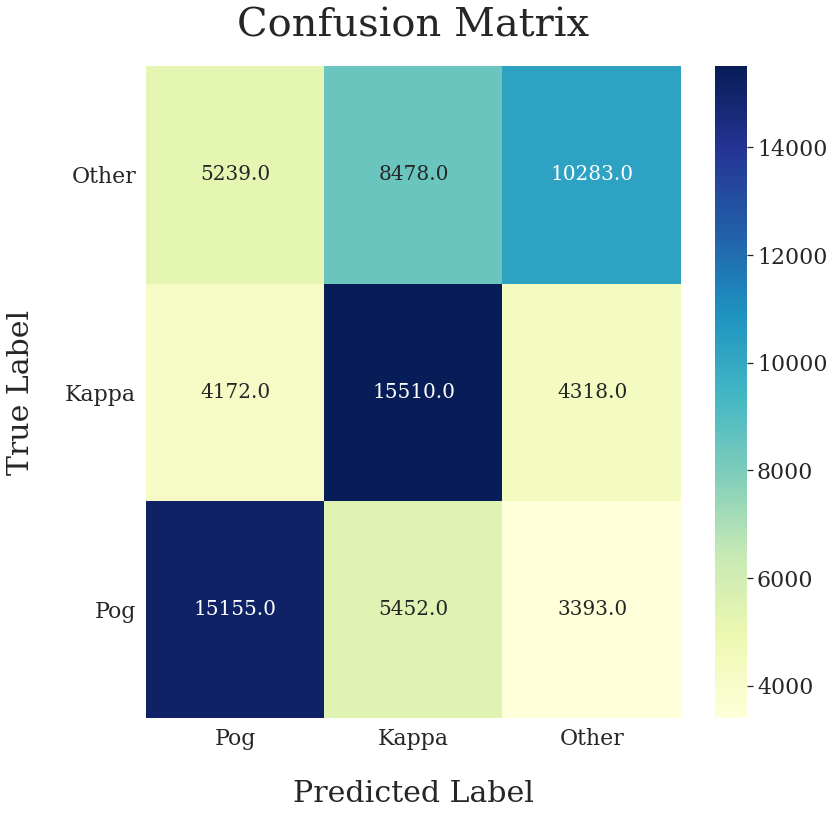

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion = confusion_matrix(y_true, y_pred_class)
confusion = np.array([[15155,  5452,  3393],
                      [ 4172, 15510,  4318],
                      [ 5239,  8478, 10283]])

f, ax = plt.subplots(figsize= (12,12))

labels = ["Pog", "Kappa", "Other"]
sns.heatmap(confusion, xticklabels=labels, yticklabels=labels, annot = True, cmap = "YlGnBu", fmt= '.1f', annot_kws={"fontsize":20})

plt.yticks(rotation=0)

ax.invert_yaxis()
ax.set_title("Confusion Matrix", fontname='DejaVu Serif', fontsize=40, pad=30)
ax.set_xlabel("Predicted Label", fontname='DejaVu Serif', fontsize=30, labelpad=30)
ax.set_ylabel("True Label", fontname='DejaVu Serif', fontsize=30, labelpad=30)

plt.rcParams['font.family'] = "DejaVu Serif"

plt.show()
# plt.savefig('cm.png')

In [3]:
history = pickle.load(open("BLSTM_1layer_128_nodense_001_dropout_2_history.pkl","rb"))
history

{'loss': [0.5566859245300293,
  0.5336248278617859,
  0.5221971273422241,
  0.5083720088005066,
  0.4958172142505646,
  0.4828302264213562,
  0.4663048982620239,
  0.45513129234313965,
  0.4425618350505829,
  0.42758190631866455],
 'acc': [0.5243333578109741,
  0.5579652786254883,
  0.5755521059036255,
  0.590996503829956,
  0.6064131855964661,
  0.6225903034210205,
  0.640701413154602,
  0.6516110897064209,
  0.6650694608688354,
  0.6792430281639099],
 'val_loss': [0.5370073914527893,
  0.5318731069564819,
  0.5268410444259644,
  0.5263255834579468,
  0.5321478247642517,
  0.5384119749069214,
  0.5408296585083008,
  0.5531864762306213,
  0.5651594996452332,
  0.5729269981384277],
 'val_acc': [0.5508055686950684,
  0.5596944689750671,
  0.5660971999168396,
  0.5687222480773926,
  0.5659999847412109,
  0.5646944642066956,
  0.566444456577301,
  0.5605972409248352,
  0.5617361068725586,
  0.5575000047683716]}

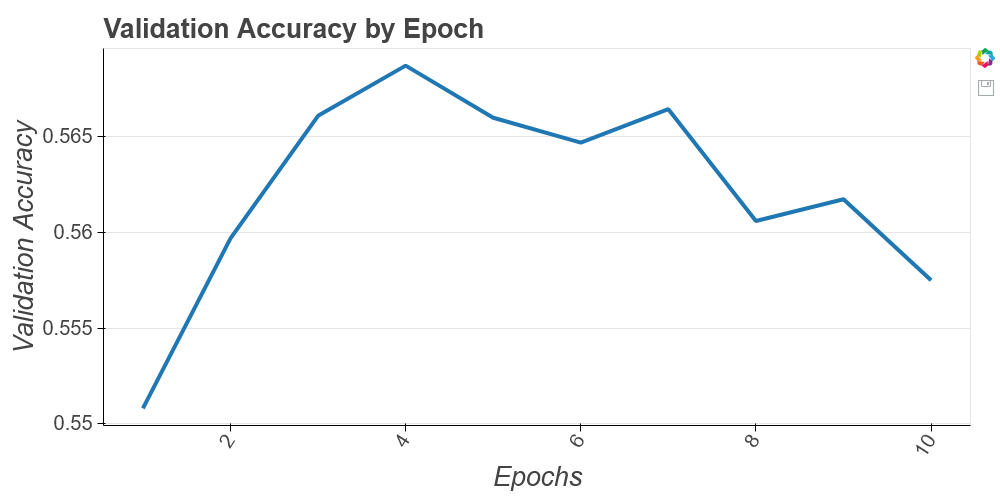

In [6]:
from bokeh.io.export import get_screenshot_as_png

x = [i for i in range(1,11)]
y = history['val_acc']
p = figure(plot_height=500, plot_width=1000,
            title="Validation Accuracy by Epoch", tools="save")
p.line(x, y, line_width=4)
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.xaxis.axis_label = "Epochs"
p.yaxis.axis_label = "Validation Accuracy"
p.xaxis.major_label_orientation = 1
p.title.text_font_size = '20pt'

p.yaxis.axis_label_text_font_size = "20pt"
p.yaxis.major_label_text_font_size = "15pt"
p.xaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "15pt"

get_screenshot_as_png(p)

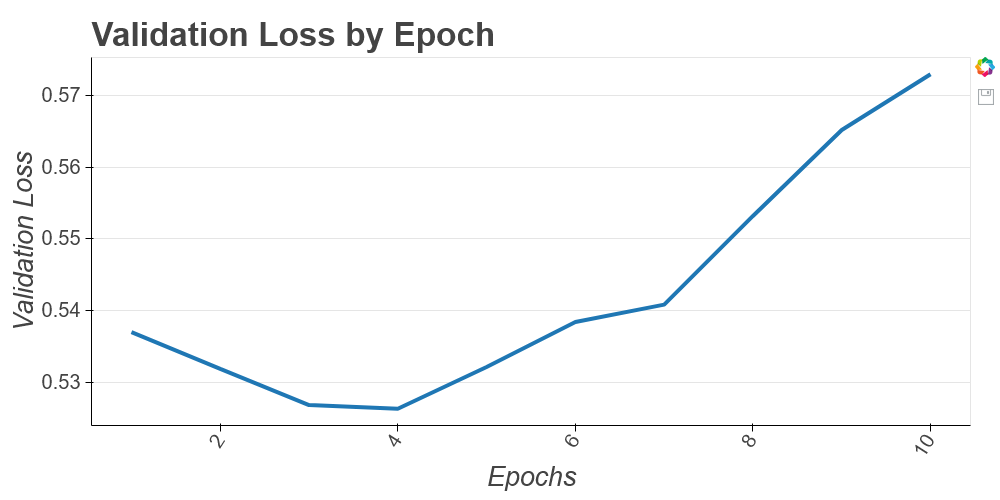

In [7]:
x = [i for i in range(1,11)]
y = history['val_loss']
p = figure(plot_height=500, plot_width=1000,
            title="Validation Loss by Epoch", tools="save")
p.line(x, y, line_width=4)
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.xaxis.axis_label = "Epochs"
p.yaxis.axis_label = "Validation Loss"
p.xaxis.major_label_orientation = 1
p.title.text_font_size = '25pt'

p.yaxis.axis_label_text_font_size = "20pt"
p.yaxis.major_label_text_font_size = "15pt"
p.xaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "15pt"
get_screenshot_as_png(p)

# Unfinished

## Sentiment Analysis

We are finally ready to analyze the sentiment of chat rooms. Our first step will be to compute the percentage of messages corresponding to an emote group by day. For this, we will use our full data set.

In [69]:
df = pd.read_csv('sodapoppin_trim.csv', parse_dates=['created_at'])

In [ ]:
def process_df(streamer):
  df = pd.read_csv(streamer +'_trim.csv', parse_dates=['created_at'])
  df['body'] = df['body'].apply(lambda x: re.sub("http\S+|[^\x00-\x7F]", "", str(x)))
  df['tokens_body'] = df['body'].apply(lambda x: twokenize.tokenizeRawTweetText(x))
  df['date'] = df['created_at'].apply(lambda x: datetime.strptime(datetime.strftime(x, '%Y %m %d %H'), '%Y %m %d %H'))

  X = global_emotes.union(streamer_emotes(streamer)).union(topffemotes)
  df['unique_emotes'] = df['tokens_body'].apply(set)
  df['unique_emotes'] = df['unique_emotes'].apply(lambda x: x.intersection(set(X)))
  df['count_emotes'] = df['unique_emotes'].apply(lambda x: len(x))

  kappas = {'Kapp', 'Kappa', 'KappaClaus', 'KappaPride', 'KappaRoss', 'KappaWealth', 'Kappu', 'Keepo'}
  pogs = {'POGGERS','Pog','PogChamp','PogU','PogYou','Pogey'}

  df['kappa'] = df['unique_emotes'].apply(lambda x: 1 if len(x.intersection(kappas)) > 0 else 0)
  df['pog'] = df['unique_emotes'].apply(lambda x: 1 if len(x.intersection(pogs)) > 0 else 0)
  df['pog'] = df['kappa'].apply(lambda x: 0 if x==1)
  df_filt['mix'] = df_filt['pog'] + df_filt['kappa']
  df_filt['other'] = df_filt['mix'].apply(lambda x: 1 if x == 0 else 0)

  
  return df[['date','tokens_body', 'pog', 'kappa', 'other']]

In [73]:
x = {'1','2'}
len(x)

2